##掛載雲端硬碟


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 下載 Colab上沒有的套件


In [2]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-0df3akzc
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-0df3akzc
  Resolved https://github.com/facebookresearch/detectron2.git to commit b1c43ffbc995426a9a6b5c667730091a384e0fa4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.2/79.2 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 56.4 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp3

In [3]:
!pip install opencv-python

## Import library

In [4]:
import os
import json
import random
import datetime
import torch
import numpy as np
import cv2
from matplotlib import pyplot as plt
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data.datasets import register_coco_instances
from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T

## 基礎工具設定



In [5]:
# 初始化 Detectron2 的日誌記錄功能
setup_logger()

def check_device():
    """檢查存在的計算裝置，使用GPU或CPU。"""
    if torch.cuda.is_available():
        print(f"可用的 GPU 數量: {torch.cuda.device_count()}")
        for i in range(torch.cuda.device_count()):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

        # 選擇 GPU（index）進行計算
        device = torch.device("cuda:0")
        torch.cuda.set_device(device)
        print(f"當前使用的 GPU 是: {torch.cuda.current_device()}")
    else:
        print("沒有可用的 GPU，使用 CPU 進行計算")
        device = torch.device("cpu")
    return device

def imshow(img):
    """顯示圖片用"""
    plt.figure(figsize=(16, 9))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## 檢查GPU


In [6]:
DEVICE = check_device()

可用的 GPU 數量: 1
GPU 0: Tesla T4
當前使用的 GPU 是: 0


In [7]:
import os
zip_path = "/content/drive/MyDrive/data.zip"
output_dir = "/content/data"

# unzip
!unzip -q "$zip_path" -d "$output_dir"

In [8]:
import os
import json
import random

def convert_to_coco(input_files, output_path):
    coco_data = {
        "images": [],
        "annotations": [],
        "categories": [
            {"id": 1, "name": "flower"},
            {"id": 2, "name": "pot"},
            {"id": 3, "name": "bud"},
        ],
    }

    annotation_counter = 1  # Annotation counter
    image_counter = 1     # Image counter

    def get_category_id(category_name):
        """Helper function to retrieve category ID."""
        return next((cat["id"] for cat in coco_data["categories"] if cat["name"] == category_name), None)

    def extract_points(shape):
        """Extract and flatten points from a shape."""
        return [coord for point in shape["points"] for coord in point]

    def compute_bbox(points):
        """Calculate the bounding box from the polygon points."""
        x_coords = [p[0] for p in points]
        y_coords = [p[1] for p in points]
        x_min, y_min = min(x_coords), min(y_coords)
        x_max, y_max = max(x_coords), max(y_coords)
        return [x_min, y_min, x_max - x_min, y_max - y_min]

    # Iterate over input files
    for file_path in input_files:
        with open(file_path, "r") as f:
            data = json.load(f)

        # Image data extraction
        file_name = os.path.basename(file_path).replace(".json", ".png")
        width, height = 1000, 1000

        # Add image entry to COCO format
        coco_data["images"].append({
            "id": image_counter,
            "file_name": os.path.join("/content/data/data", file_name),
            "width": width,
            "height": height,
        })

        # Process each shape in the current JSON file
        for shape in data["shapes"]:
            category_id = get_category_id(shape["label"])
            if category_id is None:
                continue  # Skip shapes with undefined categories

            points = shape["points"]
            segmentation = extract_points(shape)
            bbox = compute_bbox(points)
            area = bbox[2] * bbox[3]  # Width * Height

            # Add annotation entry to COCO format
            coco_data["annotations"].append({
                "id": annotation_counter,
                "image_id": image_counter,
                "category_id": category_id,
                "segmentation": [segmentation],
                "bbox": bbox,
                "area": area,
                "iscrowd": 0,
            })
            annotation_counter += 1

        image_counter += 1

    # Save COCO format data to output file
    with open(output_path, "w") as f:
        json.dump(coco_data, f, indent=4)

    print(f"COCO file saved to {output_path}")

# Directories and output paths
data_dir = "/content/data/data"
output_paths = {
    "train": "./data/train_coco_format.json",
    "val": "./data/val_coco_format.json",
    "test": "./data/test_coco_format.json",
}

# Get all JSON files in the directory
json_files = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith(".json")]

# Shuffle and split files into train, validation, and test sets 7:2:1
random.shuffle(json_files)
train_files, val_files, test_files = (
    json_files[:int(0.7 * len(json_files))],
    json_files[int(0.7 * len(json_files)):int(0.9 * len(json_files))],
    json_files[int(0.9 * len(json_files)):],
)

# Convert and save each set
convert_to_coco(train_files, output_paths["train"])
convert_to_coco(val_files, output_paths["val"])
convert_to_coco(test_files, output_paths["test"])


COCO file saved to ./data/train_coco_format.json
COCO file saved to ./data/val_coco_format.json
COCO file saved to ./data/test_coco_format.json


#Prepare dataset

Regist dataset

* 參考連結：https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html

In [9]:
from detectron2.data.datasets import register_coco_instances

# 設定檔案路徑
train_ann_path = r'./data/train_coco_format.json'
train_img_path = r'./data/'
valid_ann_path = r'./data/val_coco_format.json'
valid_img_path = r'./data/'
test_ann_path = r'./data/test_coco_format.json'
test_img_path = r'./data/'

assert os.path.isfile(train_ann_path), f'Training annotation file not found: {train_ann_path}'
assert os.path.isdir(train_img_path), f'Training image directory not found: {train_img_path}'
assert os.path.isfile(valid_ann_path), f'Validation annotation file not found: {valid_ann_path}'
assert os.path.isdir(valid_img_path), f'Validation image directory not found: {valid_img_path}'
assert os.path.isfile(test_ann_path), f'Test annotation file not found: {test_ann_path}'
assert os.path.isdir(test_img_path), f'Test image directory not found: {test_img_path}'

# 資料註冊
"""
請同學完成train、val、test資料的設定(請避免用重複名稱進行註冊)
"""
#train資料註冊
register_coco_instances("train_ds", {}, train_ann_path, train_img_path)

#val資料註冊
register_coco_instances("val_ds", {}, valid_ann_path, valid_img_path)

#test資料註冊
register_coco_instances("test_ds", {}, test_ann_path, test_img_path)

Get categories



In [10]:
# 取得類別
dataset_dicts = DatasetCatalog.get("train_ds") # (""中的內容依照註冊的train資料集名稱進行設置)
orchid_metadata = MetadataCatalog.get("train_ds") # (""中的內容依照註冊的train資料集名稱進行設置)
print(f'要辨識的內容：{orchid_metadata.thing_classes}')

[01/06 17:43:40 d2.data.datasets.coco]: Loaded 580 images in COCO format from ./data/train_coco_format.json
要辨識的內容：['flower', 'pot', 'bud']


Show some samples


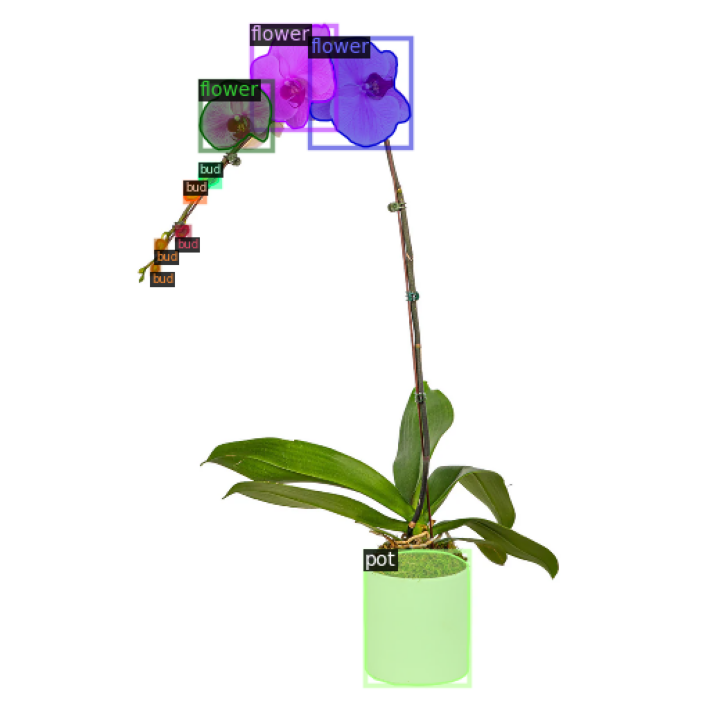

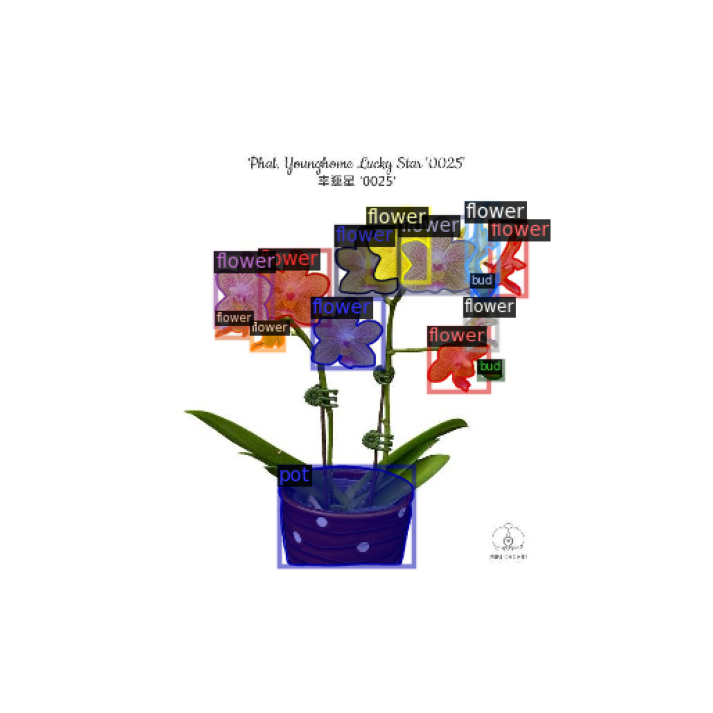

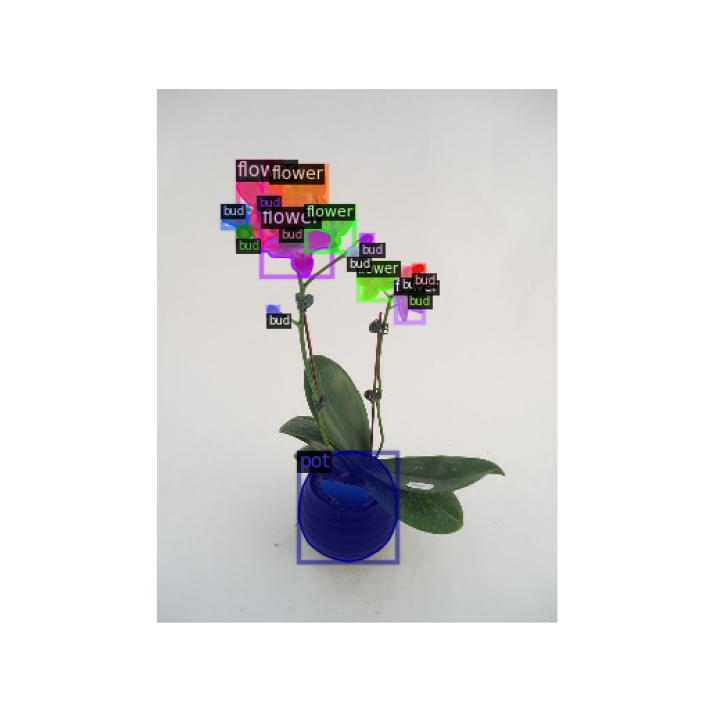

In [11]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=orchid_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    imshow(out.get_image())

#Build trainer


*   功能： 自訂訓練流程。DefaultTrainer 是 Detectron2 提供的一個方便類別，包含了預設的模型訓練邏輯。
*   為什麼要自訂？ 預設的 DefaultTrainer 在進行評估（evaluation）時，僅使用內建邏輯。自訂 MyTrainer 可以更靈活地定義如何執行評估。



In [12]:
from detectron2.data import build_detection_train_loader

# 建立 trainer (可根據需求去做修改)
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        """
        定義評估器
        """
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

In [13]:
# 下載模型
!wget https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x/138205316/model_final_a3ec72.pkl

--2025-01-06 17:43:42--  https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x/138205316/model_final_a3ec72.pkl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.78, 13.226.210.25, 13.226.210.111, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 254055290 (242M) [application/octet-stream]
Saving to: ‘model_final_a3ec72.pkl’

model_final_a3ec72. 100%[===================>] 242.29M   133MB/s    in 1.8s    

2025-01-06 17:43:44 (133 MB/s) - ‘model_final_a3ec72.pkl’ saved [254055290/254055290]



faster_rcnn_R_50+FPN

In [14]:
# 設定 config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

# 設定訓練和驗證數據集
cfg.DATASETS.TRAIN = ("train_ds",)  # 根據註冊的訓練資料集名稱進行設置
cfg.DATASETS.TEST = ("val_ds",)    # 根據註冊的驗證資料集名稱進行設置

# 指定模型的初始權重檔案
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

# 設定訓練批次大小和資料載入的工作執行緒數量
cfg.SOLVER.IMS_PER_BATCH = 8  # 訓練批次大小
cfg.DATALOADER.NUM_WORKERS = 2  # 資料載入的工作執行緒數量

# 設定 learning rate
cfg.SOLVER.BASE_LR = 0.01

# 計算並設定最大迭代次數 (MAX_ITER)
# Epoch = MAX_ITER * BATCH_SIZE / TOTAL_NUM_IMAGES
cfg.SOLVER.MAX_ITER = 100

# 設定驗證頻率
cfg.TEST.EVAL_PERIOD = 50

# 設定模型的輸出類別數
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3

# 設定模型輸出目錄, 使用時間戳記避免覆蓋
cfg.OUTPUT_DIR = os.path.join('output', datetime.datetime.now().strftime('%Y%m%d_%H%M%S_faster_rcnn'))

In [15]:
# 訓練模型
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

with open(os.path.join(cfg.OUTPUT_DIR, 'output.yaml'), "w") as f:
  f.write(cfg.dump())

trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[01/06 17:43:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:01, 108MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[01/06 17:43:47 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/06 17:44:22 d2.utils.events]:  eta: 0:01:58  iter: 19  total_loss: 1.857  loss_cls: 0.6999  loss_box_reg: 0.7033  loss_rpn_cls: 0.1243  loss_rpn_loc: 0.2835    time: 1.5165  last_time: 1.4908  data_time: 0.2638  last_data_time: 0.2074   lr: 0.0019081  max_mem: 7123M
[01/06 17:44:57 d2.utils.events]:  eta: 0:01:29  iter: 39  total_loss: 1.507  loss_cls: 0.4693  loss_box_reg: 0.7397  loss_rpn_cls: 0.06067  loss_rpn_loc: 0.2064    time: 1.5325  last_time: 1.4038  data_time: 0.2636  last_data_time: 0.2041   lr: 0.0039061  max_mem: 7123M
[01/06 17:45:12 d2.data.datasets.coco]: Loaded 166 images in COCO format from ./data/val_coco_format.json
[01/06 17:45:12 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   flower   | 1363         |    pot     | 138          |    bud     | 645          |
|          

In [16]:
# evaluation on validation set
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
predictor = DefaultPredictor(cfg)

evaluator = COCOEvaluator("val_ds", output_dir="./output") # (""中的內容依照註冊的val資料集名稱進行設置)
val_loader = build_detection_test_loader(cfg, "val_ds") # (""中的內容依照註冊的val資料集名稱進行設置)
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[01/06 17:47:11 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/20250106_174344_faster_rcnn/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[01/06 17:47:12 d2.data.datasets.coco]: Loaded 166 images in COCO format from ./data/val_coco_format.json
[01/06 17:47:12 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/06 17:47:12 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[01/06 17:47:12 d2.data.common]: Serializing 166 elements to byte tensors and concatenating them all ...
[01/06 17:47:12 d2.data.common]: Serialized dataset takes 2.31 MiB
[01/06 17:47:12 d2.evaluation.evaluator]: Start inference on 166 batches
[01/06 17:47:13 d2.evaluation.evaluator]: Inference done 11/166. Dataloading: 0.0014 s/iter. Inference: 0.0782 s/iter. Eval: 0.0003 s/iter. Total: 0.0800 s/iter. ETA=0:00:12
[01/06 17:47:18 d2.evaluation.evaluator]: Inference done 72/166. Dataloading: 0.0031 s/iter. Inference: 0.0785 s/iter. Eval: 0.0003 s/iter. Total: 0.0821 s/iter. ETA=0:00:07
[01/

In [18]:
# evaluation on test set
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
predictor = DefaultPredictor(cfg)

evaluator = COCOEvaluator("test_ds", output_dir="./output") # (""中的內容依照註冊的test資料集名稱進行設置)
test_loader = build_detection_test_loader(cfg, "test_ds") # (""中的內容依照註冊的test資料集名稱進行設置)
print(inference_on_dataset(predictor.model, test_loader, evaluator))


[01/06 17:47:56 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/20250106_174344_faster_rcnn/model_final.pth ...
[01/06 17:47:56 d2.data.datasets.coco]: Loaded 83 images in COCO format from ./data/test_coco_format.json
[01/06 17:47:56 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   flower   | 681          |    pot     | 70           |    bud     | 315          |
|            |              |            |              |            |              |
|   total    | 1066         |            |              |            |              |
[01/06 17:47:56 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/06 17:47:56 d2.data.common]: Serializing the dataset u

 使用其他蘭花照片(可以從網路上下載或是moodle上提供extra_data)進行辨識

[01/06 17:51:13 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/20250106_174344_faster_rcnn/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

/content/drive/MyDrive/extra_data/E0013.png


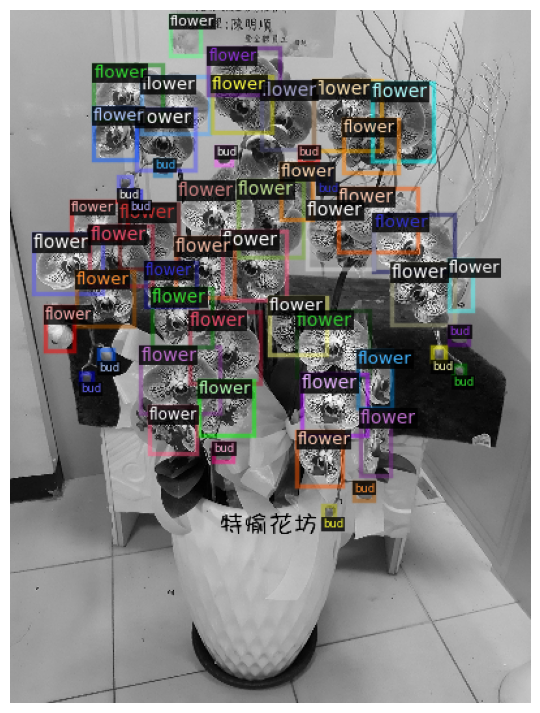

/content/drive/MyDrive/extra_data/E0006.jpg


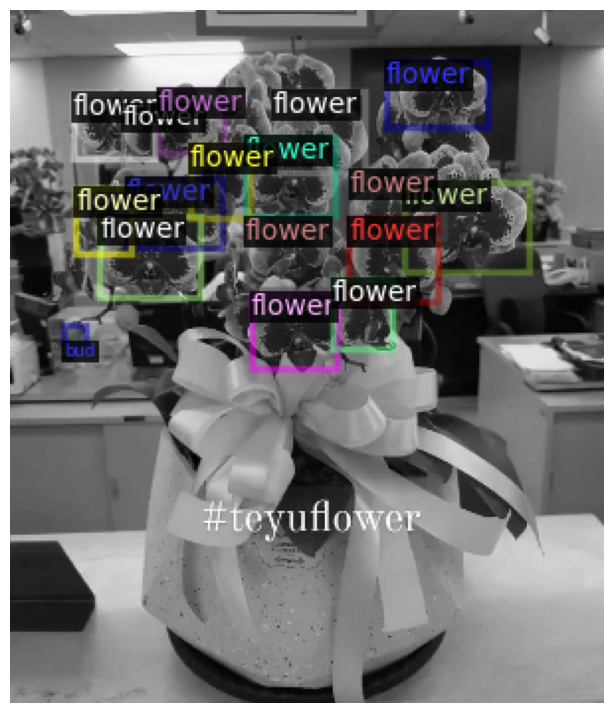

/content/drive/MyDrive/extra_data/E0003.jpg


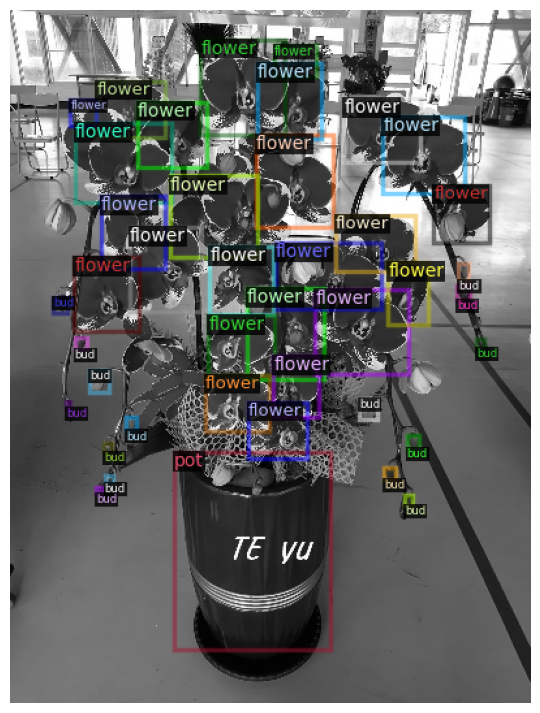

/content/drive/MyDrive/extra_data/E0010.jpg


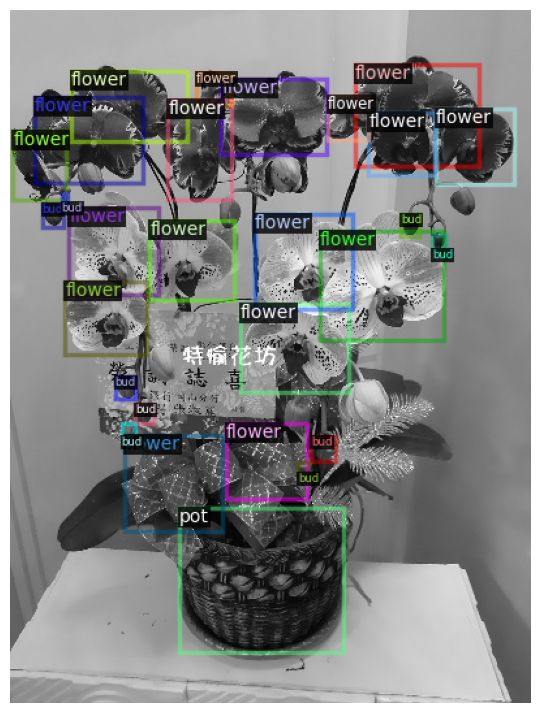

/content/drive/MyDrive/extra_data/E0014.jpg


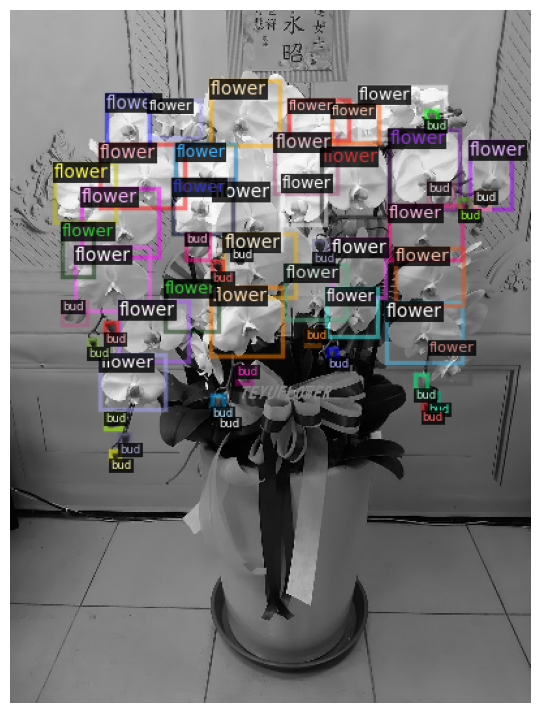

/content/drive/MyDrive/extra_data/E0019.png


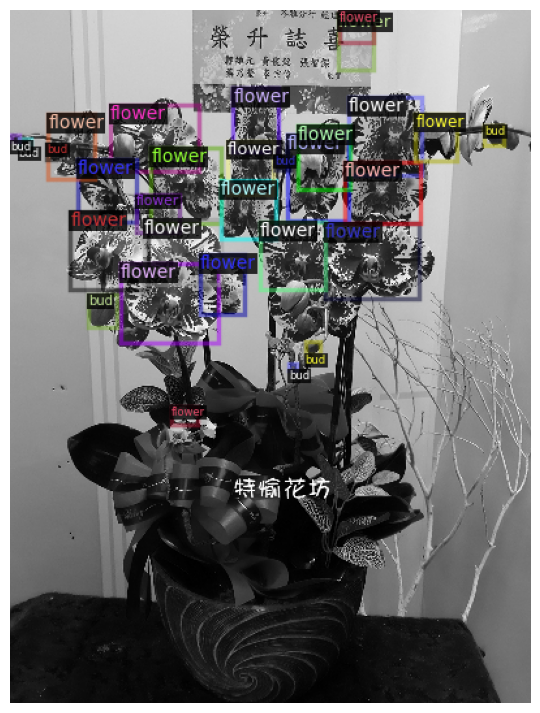

/content/drive/MyDrive/extra_data/E0017.jpg


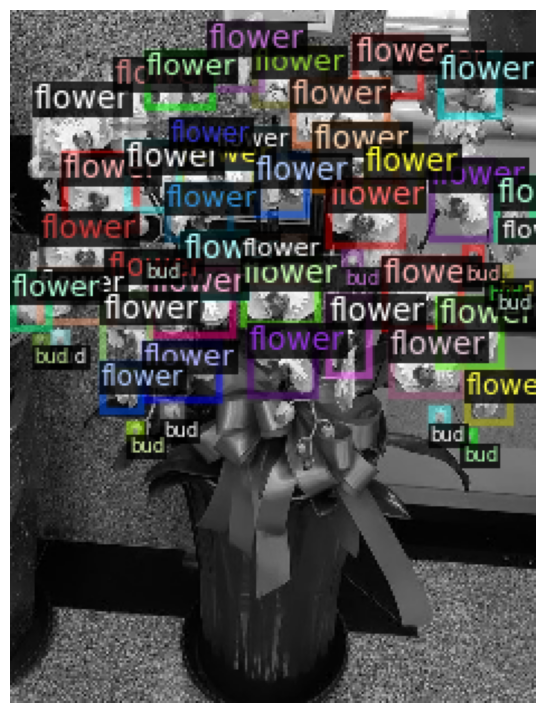

/content/drive/MyDrive/extra_data/E0005.jpg


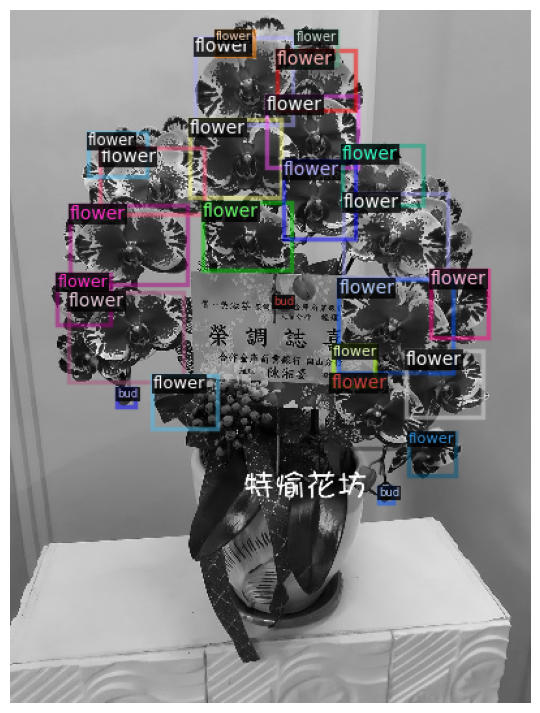

/content/drive/MyDrive/extra_data/E0004.jpg


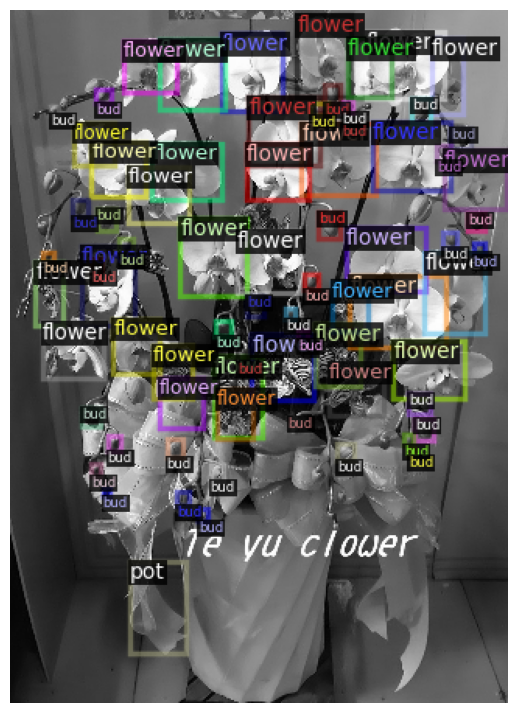

/content/drive/MyDrive/extra_data/E0012.png


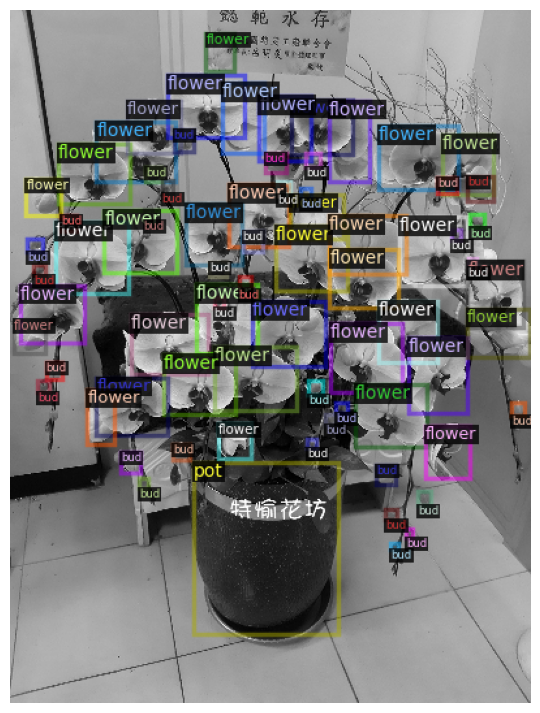

In [19]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set a custom testing threshold

predictor = DefaultPredictor(cfg)

#設置檔案路徑
test_dir = r"/content/drive/MyDrive/extra_data"

# 定義支援的圖片格式
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp')

# 從 test_dir 中選取以 .jpg 結尾的檔案
jpg_files = [file for file in os.listdir(test_dir) if file.endswith(image_extensions)]

# 隨機選取 10 個 .jpg 檔案
for file_name in random.sample(jpg_files, 10):
  test_file_path = os.path.join(test_dir, file_name)
  print(test_file_path)
  im = cv2.imread(test_file_path)

  outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format


  # 移除標籤、分數的顯示(根據需求調整)
  instances = outputs["instances"].to("cpu")
  instances.remove('scores')
  # instances.remove('pred_classes')

  # 使用Visualizer生成可視化輸出
  v = Visualizer(im[:, :, ::-1],
                   metadata=orchid_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW  # remove the colors of unsegmented pixels. This option is only available for segmentation models
                   )
  out = v.draw_instance_predictions(instances)
  output_image = out.get_image()

  # 顯示圖像
  imshow(output_image)